# News Recommendation System
##### Created by - Aditya Bhave

### Problem Statement
- iPrint is an upcoming media house. The company’s business extends across a wide range of media, including news and information services on sports, weather, education, health, research, stocks and healthcare. 
- iPrint wants to build a recommendation system to recommend news articles to its users
- As part of recommendation iPrint wants to achieve following:
    - Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
    - Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same
    
### Solution structure
- Load Data
- Exploratory Data Analysis
- Clean and filter data
- Build recommendation model using collaborative method and evaluate
- Build recommentation model using Alternating Least Square (ALS) and evaluate
- Hyper parameter tuning for ALS
- Modularize code to provide solution to problem statement
- Create data pipeline
- Suggestions for evaluation after deploying model to production

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

# Load Data and EDA

In [2]:
# import data

consumer_transactions = pd.read_csv('./data/consumer_transanctions.csv')

C:\Users\adi00\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
platform_content = pd.read_csv('./data/platform_content.csv')

In [4]:
# check the data

consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [5]:
consumer_transactions.describe()

,event_timestamp,item_id,consumer_id
count,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16
std,7.258130e+06,5.344755e+18,5.022333e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17
75%,1.474461e+09,4.441012e+18,3.766319e+18
max,1.488310e+09,9.222265e+18,9.210531e+18


In [6]:
# check the data

platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [7]:
# lets check interaction type value counts

platform_content.interaction_type.value_counts()

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64

In [8]:
# drop content that is pulled out from app

platform_content = platform_content[platform_content.interaction_type != 'content_pulled_out']

In [9]:
# lets find unique values in each column

platform_content.nunique()

event_timestamp         3046
interaction_type           1
item_id                 3047
producer_id              252
producer_session_id     2010
producer_device_info     114
producer_location         19
producer_country           5
item_type                  3
item_url                3023
title                   3003
text_description        3013
language                   5
dtype: int64

In [10]:
# lets check language value counts

platform_content.language.value_counts()

en    2211
pt     829
la       3
ja       2
es       2
Name: language, dtype: int64

In [11]:
# lets filter only english articles

platform_content = platform_content[platform_content.language == 'en']

In [12]:
# cheking the shape

platform_content.shape

(2211, 13)

In [13]:
# lets check if item_id are unique

platform_content.item_id.nunique()

2211

Since record counts match, item_id are unique

In [14]:
# check the head after filtering

platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [15]:
# lets remove unrequired columns

platform_content_df = platform_content[['item_id', 'title', 'text_description', 'item_url']]

In [16]:
platform_content_df

,item_id,title,text_description,item_url
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,http://www.nytimes.com/2016/03/28/business/dea...
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,http://cointelegraph.com/news/bitcoin-future-w...
3,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,https://cloudplatform.googleblog.com/2016/03/G...
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,https://bitcoinmagazine.com/articles/ibm-wants...
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,http://www.coindesk.com/ieee-blockchain-oxford...
...,...,...,...,...
3116,4675505028897335428,Swift Top 10 Articles For The Past Year (v.2017),"For the past year , we've ranked nearly 9,000 ...",https://medium.mybridge.co/swift-top-10-articl...
3118,-3295913657316686039,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",https://thenextweb.com/apps/2017/02/14/amazon-...
3119,3618271604906293310,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",https://code.org/about/2016
3120,6607431762270322325,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",https://www.bloomberg.com/news/articles/2017-0...


In [17]:
# lets look at consumer_transactions data now

consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [18]:
# lets check item_id count

consumer_transactions.item_id.nunique()

2987

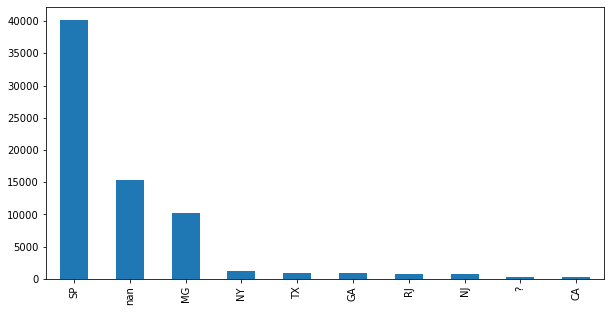

In [19]:
# lets see top 10 consumer locations

plt.figure(figsize=(10,5))
consumer_transactions.consumer_location.value_counts(dropna=False)[:10].plot(kind='bar')
plt.show()

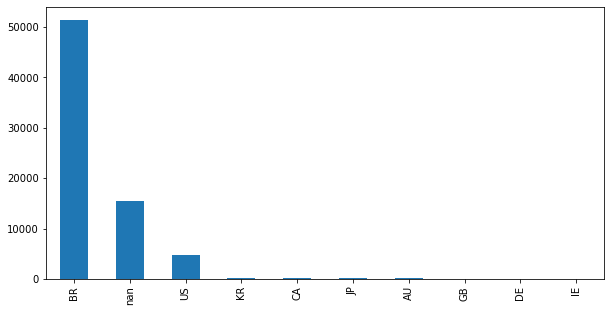

In [20]:
# lets see top 10 countries

plt.figure(figsize=(10,5))
consumer_transactions.country.value_counts(dropna=False)[:10].plot(kind='bar')
plt.show()

### Most of the users are from SP and MG location both belongs to Brazil. There are null values as well.

### Most of the users are from Brazil followed by US. There are null values as well.

In [21]:
# lets check if there are any duplicate records with item_id, consumer_id

consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [22]:
consumer_transactions[['item_id','consumer_id']].nunique()

item_id        2987
consumer_id    1895
dtype: int64

In [23]:
# check if there are any nulls in columns of interest

consumer_transactions.isna().sum()

event_timestamp             0
interaction_type            0
item_id                     0
consumer_id                 0
consumer_session_id         0
consumer_device_info    15394
consumer_location       15405
country                 15394
dtype: int64

In [24]:
consumer_transactions.shape

(72312, 8)

In [25]:
# append item_id and consumer_id and check if those are unique

(consumer_transactions.item_id.apply(str) + consumer_transactions.consumer_id.apply(str)).shape

(72312,)

In [26]:
(consumer_transactions.item_id.apply(str) + consumer_transactions.consumer_id.apply(str)).nunique()

40710

In [27]:
# so there are 72312 - 40710 = 31602 duplicate records

72312 - 40710

31602

In [28]:
# lets check value counts

temp = (consumer_transactions.item_id.apply(str) + consumer_transactions.consumer_id.apply(str)).value_counts()

In [29]:
# value counts of duplicate records

temp[temp > 1].value_counts()

2     10469
3      3179
4      1320
5       642
6       326
7       205
8       137
9        88
10       69
11       48
12       33
13       23
14       19
16       16
15       12
19       10
20        5
17        5
18        4
22        4
21        3
24        3
32        2
23        2
27        2
28        2
44        2
37        1
38        1
40        1
25        1
29        1
33        1
30        1
96        1
46        1
31        1
dtype: int64

In [30]:
# lets check one of such duplicate set

consumer_transactions[(consumer_transactions.item_id == -6642751159620064055) & (consumer_transactions.consumer_id == 2947963873628556360)]

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
60508,1478488027,content_watched,-6642751159620064055,2947963873628556360,-4966095428048230102,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60539,1478528717,content_watched,-6642751159620064055,2947963873628556360,-4966095428048230102,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60744,1478606716,content_watched,-6642751159620064055,2947963873628556360,5048855244552968148,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60746,1478608608,content_watched,-6642751159620064055,2947963873628556360,5048855244552968148,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60790,1478633346,content_watched,-6642751159620064055,2947963873628556360,5048855244552968148,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60793,1478630716,content_watched,-6642751159620064055,2947963873628556360,5048855244552968148,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
60860,1478627810,content_watched,-6642751159620064055,2947963873628556360,5048855244552968148,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
61283,1479246851,content_watched,-6642751159620064055,2947963873628556360,5819084728106131297,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
61487,1478535273,content_watched,-6642751159620064055,2947963873628556360,-4966095428048230102,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
61494,1479259847,content_watched,-6642751159620064055,2947963873628556360,2282099478532957085,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR


In [31]:
consumer_transactions.shape

(72312, 8)

## There are duplicate records in consumer_transaction
To remove duplicate we can use one of following strategies
- Pick the latest record
- Pick the record with best rating
- Pick all the records and sum of them as rating

In [32]:
# lets remove duplicate records

consumer_transactions = consumer_transactions.drop_duplicates(subset=['item_id', 'consumer_id'], keep='last')

In [33]:
# reusable function to plot barplot

def barplot(data, figsize=(5,5)):
    plt.figure(figsize=figsize)    
    return sns.barplot(x=data.index, y=data.values)

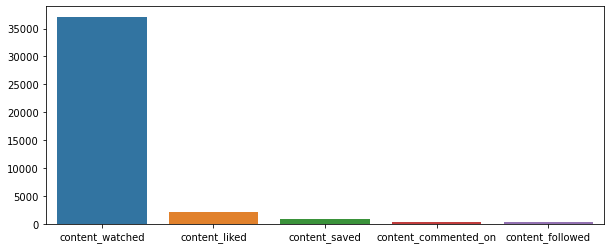

In [34]:
#  visualize interaction_type

barplot(consumer_transactions.interaction_type.value_counts(), (10,4))
plt.show()

### Above graph shows that most people just watch the content. Very few like, save, comment or follow.



### Lets create ratings column

In [35]:
# Defined ratings dictionary. We will use simple mapping based on interaction type.

ratings_dict = {
    'content_followed': 5,
    'content_commented_on': 4,
    'content_saved': 3,
    'content_liked': 2,
    'content_watched': 1
}

In [36]:
ratings_dict

{'content_followed': 5,
 'content_commented_on': 4,
 'content_saved': 3,
 'content_liked': 2,
 'content_watched': 1}

In [37]:
# create ratings column

consumer_transactions['ratings'] = consumer_transactions.interaction_type.map(ratings_dict)

In [38]:
# check first two rows for ratings

consumer_transactions.head(2)

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
12,1465415228,content_watched,3460026829794173084,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR,1
17,1465412288,content_watched,-7820640624231356730,-445337111692715325,5611481178424124714,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1


In [39]:
# remove duplicate item-user rows. keep the row with max ratings

pd.DataFrame(consumer_transactions.groupby(['item_id', 'consumer_id']).ratings.max()).reset_index()

,item_id,consumer_id,ratings
0,-9222795471790223670,-6944500707172804068,2
1,-9222795471790223670,-5868110530814399805,1
2,-9222795471790223670,-1032019229384696495,5
3,-9222795471790223670,1895326251577378793,4
4,-9222795471790223670,8968131284214320024,2
...,...,...,...
40705,9222265156747237864,-7540738139248278851,1
40706,9222265156747237864,-3596626804281480007,1
40707,9222265156747237864,692689608292948411,1
40708,9222265156747237864,2873028073541627603,1


In [40]:
# remove duplicate item-user rows. keep sum of all ratings

pd.DataFrame(consumer_transactions.groupby(['item_id', 'consumer_id']).ratings.sum()).reset_index()

,item_id,consumer_id,ratings
0,-9222795471790223670,-6944500707172804068,2
1,-9222795471790223670,-5868110530814399805,1
2,-9222795471790223670,-1032019229384696495,5
3,-9222795471790223670,1895326251577378793,4
4,-9222795471790223670,8968131284214320024,2
...,...,...,...
40705,9222265156747237864,-7540738139248278851,1
40706,9222265156747237864,-3596626804281480007,1
40707,9222265156747237864,692689608292948411,1
40708,9222265156747237864,2873028073541627603,1


In [41]:
# ratings value counts

consumer_transactions['ratings'].value_counts()

1    37106
2     2131
3      913
4      301
5      259
Name: ratings, dtype: int64

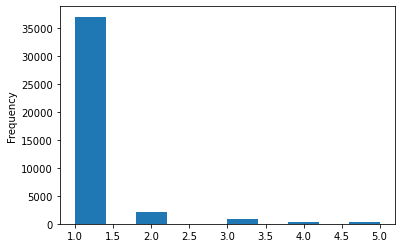

In [42]:
# lets plot ratings to find trends

consumer_transactions.ratings.plot(kind='hist')
plt.show()

### Lets analyze platform content now

In [43]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [44]:
# lets see shape of platform_content

platform_content.shape

(2211, 13)

In [45]:
# lets check unique item ids

platform_content.item_id.nunique()

2211

In [46]:
# lets check country counts in platform_content

platform_content.producer_country.value_counts()

BR    402
US     57
CA      5
AU      2
PT      1
Name: producer_country, dtype: int64

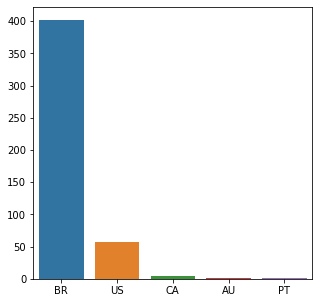

In [47]:
# lets plot barplot

barplot(platform_content.producer_country.value_counts(dropna=False))
plt.show()

### We see that the content produced is in Brazil

In [48]:
# lets check item_types

platform_content.item_type.value_counts()

HTML     2199
VIDEO       7
RICH        5
Name: item_type, dtype: int64

Most of items are of HTML type

In [49]:
# lets check language

platform_content.language.value_counts()

en    2211
Name: language, dtype: int64

All content belongs to english language

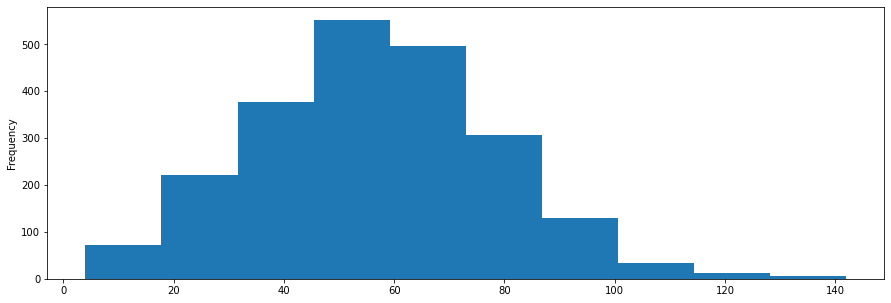

In [50]:
# lets check length of title

plt.figure(figsize=(15,5))
platform_content.title.str.len().plot(kind='hist')
plt.show()

Most of the titles are 600 chars long

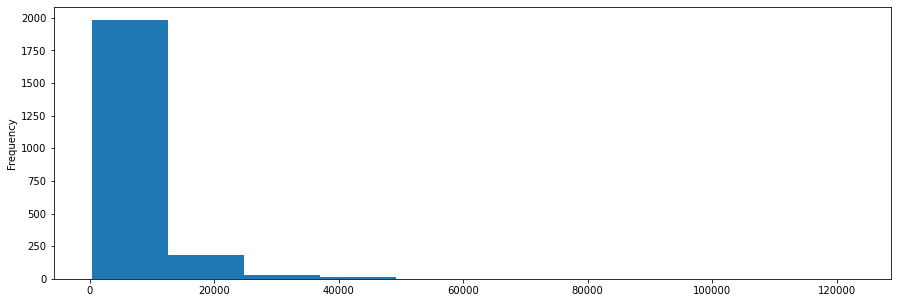

In [51]:
# lets check text_description

plt.figure(figsize=(15,5))
platform_content.text_description.str.len().plot(kind='hist')
plt.show()

Most of the text_description are 2000 chars long

In [52]:
platform_content.isna().sum()

event_timestamp            0
interaction_type           0
item_id                    0
producer_id                0
producer_session_id        0
producer_device_info    1744
producer_location       1744
producer_country        1744
item_type                  0
item_url                   0
title                      0
text_description           0
language                   0
dtype: int64

The required columns are not null in platform_content dataframe

# Collaborative (User Similarity)

In [53]:
# Creating user-item matrix from consumer_transactions

In [54]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
12,1465415228,content_watched,3460026829794173084,1908339160857512799,9121879357144259163,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR,1
17,1465412288,content_watched,-7820640624231356730,-445337111692715325,5611481178424124714,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1
22,1465415060,content_watched,-1492913151930215984,4254153380739593270,8743229464706506141,NaN,NaN,NaN,1
26,1465415695,content_watched,7763750328910542816,1908339160857512799,9121879357144259163,NaN,NaN,NaN,1
30,1465413771,content_watched,3064370296170038610,3609194402293569455,1143207167886864524,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR,1


## There are duplicate rows in consumer_transactions
### Some users have watched the article multiple times. This means that they like that article.
### Hence, we will sum all the ratings for duplicate column to get final ratings
- Other option would be to pick maximum rating (which we will try later)

In [55]:
# Using sum of all ratings

consumer_transactions_df = pd.DataFrame(consumer_transactions.groupby(['item_id', 'consumer_id']).ratings.sum()).reset_index()

In [56]:
consumer_transactions_df.head()

,item_id,consumer_id,ratings
0,-9222795471790223670,-6944500707172804068,2
1,-9222795471790223670,-5868110530814399805,1
2,-9222795471790223670,-1032019229384696495,5
3,-9222795471790223670,1895326251577378793,4
4,-9222795471790223670,8968131284214320024,2


In [57]:
consumer_transactions_df.nunique()

item_id        2987
consumer_id    1895
ratings           5
dtype: int64

In [58]:
consumer_transactions_df.isna().sum()

item_id        0
consumer_id    0
ratings        0
dtype: int64

In [59]:
# split in train and test

train, test = train_test_split(consumer_transactions_df, test_size=0.20, random_state=31)

In [60]:
print(train.shape)
print(test.shape)

(32568, 3)
(8142, 3)


In [61]:
# lets create pivot

data_matrix_train = train.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)

In [62]:
data_matrix_train.head()

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
data_matrix_train.shape

(1838, 2938)

In [64]:
# find user similarity

user_similarity = 1 - pairwise_distances(data_matrix_train, metric='cosine')

In [65]:
# user_similarity dataftame

user_similarity_df = pd.DataFrame(user_similarity, index=data_matrix_train.index, columns=data_matrix_train.index)

In [66]:
# dot product with data matrix to get predicted ratings

user_predicted_ratings_train = np.dot(user_similarity, data_matrix_train.fillna(0))
user_predicted_ratings_train

array([[1.12645807, 0.23982528, 0.49211828, ..., 0.21331497, 0.84801491,
        0.20977706],
       [0.20160125, 0.35208308, 0.        , ..., 0.06013097, 0.20163246,
        0.09449112],
       [0.09079192, 3.35769539, 0.23561909, ..., 0.01513069, 0.31608735,
        0.0568191 ],
       ...,
       [0.17476238, 0.18257419, 0.32811779, ..., 0.00425013, 0.14782313,
        0.05783415],
       [0.50788746, 0.31327228, 0.47498548, ..., 0.09154642, 0.55975289,
        0.1108713 ],
       [0.26876988, 0.10038857, 0.83393448, ..., 0.07871875, 0.76714313,
        0.14908571]])

In [67]:
# predicted ratings dataframe

user_predicted_ratings_train_df = pd.DataFrame(user_predicted_ratings_train, index=data_matrix_train.index, columns=data_matrix_train.columns)

In [68]:
# lets look at the predicted ratings

user_predicted_ratings_train_df.head()

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,1.126458,0.239825,0.492118,1.963289,0.099659,0.832103,0.035768,0.991309,0.044606,0.244178,...,0.815028,0.501679,0.393928,0.185867,0.786173,0.360579,0.540780,0.213315,0.848015,0.209777
-9212075797126931087,0.201601,0.352083,0.000000,0.592995,0.000000,0.239467,0.000000,0.192781,0.105556,0.000000,...,0.000000,0.085097,0.086706,0.000000,0.188008,0.037062,0.108362,0.060131,0.201632,0.094491
-9207251133131336884,0.090792,3.357695,0.235619,0.336015,0.028904,0.700284,0.000000,0.628181,0.000000,0.102598,...,0.225456,0.111041,0.027555,0.022698,0.107449,0.377775,0.218334,0.015131,0.316087,0.056819
-9199575329909162940,0.838551,0.000000,0.114621,0.092281,0.096297,0.044646,0.000000,0.291021,0.000000,0.000000,...,0.442611,0.174201,0.161005,0.242085,0.087189,0.030106,0.060291,0.033559,0.109925,0.000000
-9196668942822132778,0.034627,0.000000,0.853376,0.741227,0.034627,0.362210,0.028796,0.151398,0.021547,0.020672,...,0.067727,0.098649,0.028172,0.034627,0.562396,0.303261,0.145699,0.016175,0.248784,0.028796


In [69]:
user_predicted_ratings_train_df.shape

(1838, 2938)

In [70]:
# we need to filter records from test which are present in train. 
# lets create a copy of test set

test_copy = test.copy()

In [71]:
test.shape

(8142, 3)

In [72]:
# filter records in test

test = test[test.consumer_id.isin(train.consumer_id) & test.item_id.isin(train.item_id)]
test.shape

(8014, 3)

In [73]:
test.head()

,item_id,consumer_id,ratings
32395,5338677278233757627,-6533304626998890151,1
32186,5293701842202310496,-3596626804281480007,1
28568,3582716808949240433,-8674958742744576254,1
4706,-7113155163062752691,-3216836291203563246,1
11075,-4333957157636611418,3302556033962996625,1


In [74]:
test.nunique()

item_id        2185
consumer_id    1255
ratings           5
dtype: int64

In [75]:
# creating data matrix of test

data_matrix_test = test.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)

In [76]:
data_matrix_test.head()

item_id,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,...,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
data_matrix_test.shape

(1255, 2185)

In [78]:
# filtering data which is present in user-similarity matrix

test_user_similarity_df = user_similarity_df[user_similarity_df.index.isin(data_matrix_test.index)]
test_user_similarity_df = test_user_similarity_df[test_user_similarity_df.index]

In [79]:
# dot product with user-similarity to get predicted ratings from test

test_user_predicted_ratings = np.dot(test_user_similarity_df, data_matrix_test)
test_user_predicted_ratings = pd.DataFrame(test_user_predicted_ratings, index=data_matrix_test.index, columns=data_matrix_test.columns)
test_user_predicted_ratings

item_id,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,...,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.000000,0.132167,0.356588,0.014441,0.281137,0.079671,0.044606,0.000000,0.100569,0.0,...,0.368600,0.000000,0.119608,0.243637,0.090872,0.000000,0.275921,0.076462,0.132900,0.042687
-9212075797126931087,0.000000,0.047460,0.113319,0.000000,0.129733,0.017700,0.105556,0.000000,0.000000,0.0,...,0.000000,0.000000,0.019811,0.019811,0.040320,0.000000,0.019811,0.000000,0.145392,0.025254
-9207251133131336884,0.545545,0.029161,0.235925,0.049326,0.166482,0.000000,0.000000,0.000000,0.024754,0.0,...,0.231376,0.108148,0.034199,0.000000,0.000000,0.000000,0.102041,0.027555,0.000000,0.029161
-9199575329909162940,0.000000,0.000000,0.063182,0.000000,0.128002,0.011194,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.025059,0.025059,0.008500,0.000000,0.025059,0.015093,0.000000,0.000000
-9196668942822132778,0.000000,0.095632,0.302891,0.000000,0.179062,0.000000,0.021547,0.000000,0.051434,0.0,...,0.054074,0.000000,0.016175,0.036848,0.000000,0.000000,0.016175,0.028796,0.057166,0.041239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165571805999894845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,3.000000,0.093659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9187866633451383747,0.000000,0.013391,0.172495,0.000000,0.162133,0.032020,0.111392,0.000000,0.025854,0.0,...,0.804494,0.000000,0.029806,0.027214,0.032419,0.000000,0.026783,0.000000,0.042220,0.000000
9191849144618614467,0.179284,0.098034,0.126403,0.135086,0.183533,0.124590,0.058415,0.000000,0.000000,0.0,...,0.519992,0.088852,0.225033,0.099528,0.004250,0.000000,0.059066,0.079070,0.254216,0.055902


## Evaluation User-User (Collaborative)
In evaluation, we will compare actual vs predicted ratings and find metrics such as RMSE, MAE, PrecisionAtK etc.
The easiest way is to find predicted rating for each row in test set and then perform comparison

In [80]:
# calculate predicted_ratings for test set

test = test.assign(predicted_ratings=[test_user_predicted_ratings.loc[consumerId][itemId]
                                      for itemId,consumerId,rating in test.to_numpy()])

test

,item_id,consumer_id,ratings,predicted_ratings
32395,5338677278233757627,-6533304626998890151,1,1.942807
32186,5293701842202310496,-3596626804281480007,1,1.476722
28568,3582716808949240433,-8674958742744576254,1,1.068299
4706,-7113155163062752691,-3216836291203563246,1,2.176330
11075,-4333957157636611418,3302556033962996625,1,2.592598
...,...,...,...,...
39999,8890720798209849691,-3596626804281480007,4,5.578705
31122,4814419120794996930,-453678802103139441,1,1.278364
20629,90383487344892230,2901546026085255870,1,1.301990
17904,-1111518890369033396,-5230721907253934520,1,1.849743


In [81]:
# lets look at some predicted ratings

test['predicted_ratings'].to_numpy()

array([1.94280652, 1.47672192, 1.06829878, ..., 1.30199008, 1.84974267,
       1.29445606])

In [82]:
# function to calculate rmse

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [83]:
# calculate rmse for test set

rmse(test['predicted_ratings'].to_numpy(), test['ratings'].to_numpy())

0.6098859530699084

In [84]:
# find predicted ratings

train = train.assign(predicted_ratings=[user_predicted_ratings_train_df.loc[consumerId][itemId] for itemId,consumerId,rating in train.to_numpy()])

In [85]:
train

,item_id,consumer_id,ratings,predicted_ratings
32208,5293701842202310496,3609194402293569455,1,4.569953
9496,-5065077552540450930,-2375109818259049493,1,12.357605
35542,6989198691754522425,-6153009241569363021,1,4.450348
1313,-8742648016180281673,9191849144618614467,1,6.862575
37545,7814856426770804213,-6734098108417569342,1,6.307303
...,...,...,...,...
33594,6015995473246774717,-1532427549655023552,1,3.554825
3735,-7570652411388243006,-1669398169117380092,1,5.438378
14946,-2516726696296387544,8913362709216003291,1,1.630641
27518,3162261384765351942,1202287501580555390,1,2.202520


In [86]:
# calculate rmse for train set

rmse(train['predicted_ratings'].to_numpy(), train['ratings'].to_numpy())

5.815813456183381

In [87]:
# calculate rmse for test set

rmse(np.array(test_user_predicted_ratings), np.array(data_matrix_test))

0.6098859530699084

In [88]:
# function to calculate mae

def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [89]:
# find mae of train set

mae(train['predicted_ratings'].to_numpy(), train['ratings'].to_numpy())

3.1220519218207983

In [90]:
# find mae of test

mae(test['predicted_ratings'].to_numpy(), test['ratings'].to_numpy())

0.40642365489125754

## Global Precision @k

In [91]:
# function for finding precision at k by consumer id

def getPrecisionAtK(df, consumerId, k=10):
    by_ratings = df[df.consumer_id == consumerId].sort_values(by='ratings', ascending=False)[:k].item_id
    by_pred_ratings = df[df.consumer_id == consumerId].sort_values(by='predicted_ratings', ascending=False)[:k].item_id

    return by_pred_ratings.isin(by_ratings).sum()/k

In [92]:
# lets try for one of the consumer

getPrecisionAtK(test, 434517017614495946, 10)

0.9

In [93]:
# find global precision at 5 for test set

sum([getPrecisionAtK(test, consumerId, 5) for consumerId in test.consumer_id.unique()])/len(test.consumer_id.unique())

0.48541832669323254

In [94]:
train

,item_id,consumer_id,ratings,predicted_ratings
32208,5293701842202310496,3609194402293569455,1,4.569953
9496,-5065077552540450930,-2375109818259049493,1,12.357605
35542,6989198691754522425,-6153009241569363021,1,4.450348
1313,-8742648016180281673,9191849144618614467,1,6.862575
37545,7814856426770804213,-6734098108417569342,1,6.307303
...,...,...,...,...
33594,6015995473246774717,-1532427549655023552,1,3.554825
3735,-7570652411388243006,-1669398169117380092,1,5.438378
14946,-2516726696296387544,8913362709216003291,1,1.630641
27518,3162261384765351942,1202287501580555390,1,2.202520


In [95]:
# find global precision at 5 for train set

sum([getPrecisionAtK(train, consumerId, 5) for consumerId in train.consumer_id.unique()])/len(train.consumer_id.unique())

0.46670293797606527

In [96]:
# find global precision at 10 for test set

sum([getPrecisionAtK(test, consumerId, 10) for consumerId in test.consumer_id.unique()])/len(test.consumer_id.unique())

0.35752988047809175

In [97]:
# find global precision at 10 for train set

sum([getPrecisionAtK(train, consumerId, 10) for consumerId in train.consumer_id.unique()])/len(train.consumer_id.unique())

0.41675734494015654

### Analysis
- RMSE
    - Train set = 5.81
    - Test set = 0.60
- MAE
    - Train set = 3.12
    - Test set = 0.40
- Global precision at 10 - 
    - Train set = 0.41
    - Test set = 0.35

# Collaborative (Item Similarity)
- Lets find item similarity by using transpose of user-item matrix
- We will find cosine similarity of the transposed matrix

In [98]:
# lets create pivot

data_matrix = consumer_transactions_df.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)

In [99]:
data_matrix.head()

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
data_matrix.shape

(1895, 2987)

In [101]:
# lets find cosine similarity of transponsed matrix

item_similarity = 1 - pairwise_distances(data_matrix.T, metric='cosine')

In [102]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.28867513, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.0410305 ,
        0.09534626],
       ...,
       [0.28867513, 0.        , 0.        , ..., 1.        , 0.07856742,
        0.18257419],
       [0.        , 0.        , 0.0410305 , ..., 0.07856742, 1.        ,
        0.0860663 ],
       [0.        , 0.        , 0.09534626, ..., 0.18257419, 0.0860663 ,
        1.        ]])

In [103]:
# creating dataframe from similarity matrix

item_similarity_df = pd.DataFrame(item_similarity, index=data_matrix.T.index, columns=data_matrix.T.index)

In [104]:
item_similarity_df

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
item_id,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,1.000000,0.0,0.000000,0.166667,0.070711,0.000000,0.0,0.329983,0.000000,0.000000,...,0.392232,0.182574,0.000000,0.632456,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000
-9216926795620865886,0.000000,1.0,0.000000,0.000000,0.000000,0.062017,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-9194572880052200111,0.000000,0.0,1.000000,0.150756,0.000000,0.083624,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100504,0.337100,0.044455,0.000000,0.041030,0.095346
-9192549002213406534,0.166667,0.0,0.150756,1.000000,0.000000,0.138675,0.0,0.117851,0.117851,0.102062,...,0.000000,0.152145,0.083333,0.105409,0.277778,0.074536,0.049147,0.144338,0.158763,0.000000
-9190737901804729417,0.070711,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.129099,0.000000,0.223607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213260650272029784,0.000000,0.0,0.337100,0.074536,0.000000,0.124035,0.0,0.052705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.074536,1.000000,0.065938,0.000000,0.060858,0.000000
9215261273565326920,0.000000,0.0,0.044455,0.049147,0.000000,0.245358,0.0,0.208514,0.000000,0.180579,...,0.000000,0.323029,0.442326,0.000000,0.049147,0.065938,1.000000,0.255377,0.080257,0.093250
9217155070834564627,0.288675,0.0,0.000000,0.144338,0.000000,0.000000,0.0,0.204124,0.000000,0.000000,...,0.000000,0.210819,0.288675,0.365148,0.000000,0.000000,0.255377,1.000000,0.078567,0.182574


In [105]:
# finding similar items for a random item id

item_similarity_df[-9194572880052200111].sort_values(ascending=False)[1:]

item_id
 3716124214746295857    0.580259
 2834072258350675251    0.569803
-9020955625521881630    0.497468
-2462651558329037716    0.479702
 1737303669706106633    0.452267
                          ...   
-389749390447363927     0.000000
-348408475077850711     0.000000
 6943483335823457240    0.000000
-330801551666885085     0.000000
-9222795471790223670    0.000000
Name: -9194572880052200111, Length: 2986, dtype: float64

# ALS (Alternating least squares)

In [106]:
# importing packages required for ALS

import implicit
from implicit.evaluation import train_test_split as impl_train_test_split

from scipy.sparse import csr_matrix

import tqdm

In [107]:
# picking random alpha

alpha = 40

In [108]:
# creating a copy of dataframe

consumer_transactions_als_df = consumer_transactions_df.copy()

In [109]:
# create mapping dictionary

all_item_ids = list(platform_content.item_id)
all_item_ids.extend(list(consumer_transactions.item_id))

mapItemIdToNumber = {item_id:i for i, item_id in enumerate(sorted(list(set(all_item_ids))))}
mapConsumerIdToNumber = {consumer_id:i for i, consumer_id in enumerate(sorted(list(set(consumer_transactions.consumer_id))))}

In [110]:
# als cannot work with nedative indexes
# mapping consumer id and item id 

consumer_transactions_als_df['consumer_id_mapped'] = consumer_transactions_als_df.consumer_id.map(mapConsumerIdToNumber)
consumer_transactions_als_df['item_id_mapped'] = consumer_transactions_als_df.item_id.map(mapItemIdToNumber)

In [111]:
# filter only required columns

consumer_transactions_als_df = consumer_transactions_als_df[['consumer_id_mapped', 'item_id_mapped', 'ratings']]

In [112]:
consumer_transactions_als_df.head()

,consumer_id_mapped,item_id_mapped,ratings
0,226,0,2
1,333,0,1
2,831,0,5
3,1142,0,4
4,1867,0,2


In [113]:
df = consumer_transactions_als_df

In [114]:
# lets create csr matrix - sparse user item

sparse_user_item = csr_matrix((list([alpha]*consumer_transactions_als_df.ratings), (df['consumer_id_mapped'], df['item_id_mapped']) ))

In [115]:
# lets see the shape

sparse_user_item.shape

(1895, 3049)

In [116]:
# sparse item user matrix a transpose of sparse user item

sparse_item_user = sparse_user_item.T.tocsr()

In [117]:
# split in train and test. results may vary in subsequent runs becase there is no random_state in split

train_als, test_als = impl_train_test_split(sparse_item_user, train_percentage=0.20)

In [118]:
# create als model

model = implicit.als.AlternatingLeastSquares(factors=200, regularization=0.01, iterations=1000, calculate_training_loss=True)

In [119]:
# fit the model

model.fit(train_als)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [120]:
# find precision at k (k=10)

implicit.evaluation.precision_at_k(model, train_als.T, test_als.T, 10, show_progress=True)

  0%|          | 0/1895 [00:00<?, ?it/s]

0.04193909957033439

In [121]:
# try to recommend for random user id = 10

model.recommend(10, sparse_item_user, 10)

[(2235, 0.9942686),
 (581, 0.9904104),
 (2601, 0.990321),
 (1748, 0.99006397),
 (169, 0.9885875),
 (2062, 0.948862),
 (1632, 0.92569363),
 (2960, 0.9256935),
 (2201, 0.8066857),
 (3047, 0.63323766)]

In [122]:
# searching for best hyper params

factors = [50, 100]
regularizations = [0.1, 0.01, 0.001]
iterations = [500, 1000]

results = {}

for i in iterations:
    for r in regularizations:
        for f in factors:
            model = implicit.als.AlternatingLeastSquares(factors=f, regularization=r, iterations=i, calculate_training_loss=False)
            model.fit(train_als)
            precision_at_10 = implicit.evaluation.precision_at_k(model, train_als.T, test_als.T, 10, show_progress=False)
            
            results[(i, r, f)] = precision_at_10
            print(f'Finished iterations:{i}, regularization: {r}, factors: {f}: {precision_at_10}')
            


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.1, factors: 50: 0.07659256491686904


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.1, factors: 100: 0.06043340183074911


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.01, factors: 50: 0.07883429852419205


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.01, factors: 100: 0.05977956286194657


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.001, factors: 50: 0.07948813749299458


  0%|          | 0/500 [00:00<?, ?it/s]

Finished iterations:500, regularization: 0.001, factors: 100: 0.061274051933495235


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.1, factors: 50: 0.08014197646179712


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.1, factors: 100: 0.05921912946011582


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 50: 0.0781804595553895


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 100: 0.06033999626377732


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 50: 0.0781804595553895


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 100: 0.06052680739772091


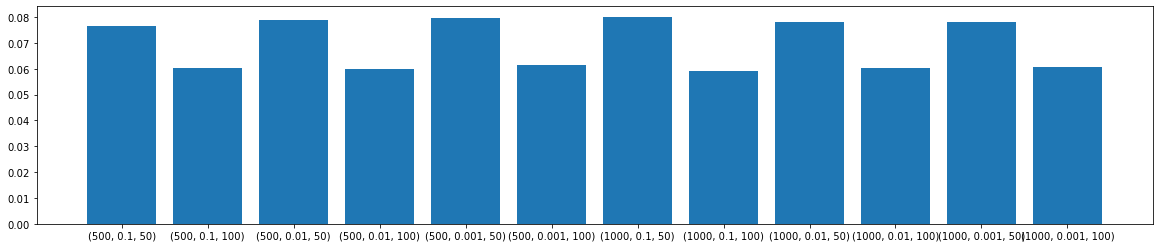

In [123]:
# results

plt.figure(figsize=(20,4))
plt.bar(range(len(results)), results.values(), align='center')  # python 2.x
plt.xticks(range(len(results)), results.keys())  # in python 2.x

plt.show()

### Analysis
- Less factors results in better results
- Regularization best value is 0.001
- Iterations : 1000 is good enough

In [124]:
# lets update values and perform search again

factors = [2,5,7,10,20]
regularizations = [0.01, 0.001]
iterations = [1000]

results = {}

for i in iterations:
    for r in regularizations:
        for f in factors:
            model = implicit.als.AlternatingLeastSquares(factors=f, regularization=r, iterations=i, calculate_training_loss=False)
            model.fit(train_als)
            precision_at_10 = implicit.evaluation.precision_at_k(model, train_als.T, test_als.T, 10, show_progress=False)
            
            results[(i, r, f)] = precision_at_10
            print(f'Finished iterations:{i}, regularization: {r}, factors: {f}: {precision_at_10}')
            


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 2: 0.09546048944517094


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 5: 0.09938352325798618


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 7: 0.09060339996263778


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 10: 0.09564730057911451


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.01, factors: 20: 0.09237810573510181


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 2: 0.09564730057911451


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 5: 0.10059779562861947


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 7: 0.09676816738277601


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 10: 0.09742200635157855


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished iterations:1000, regularization: 0.001, factors: 20: 0.09125723893144032


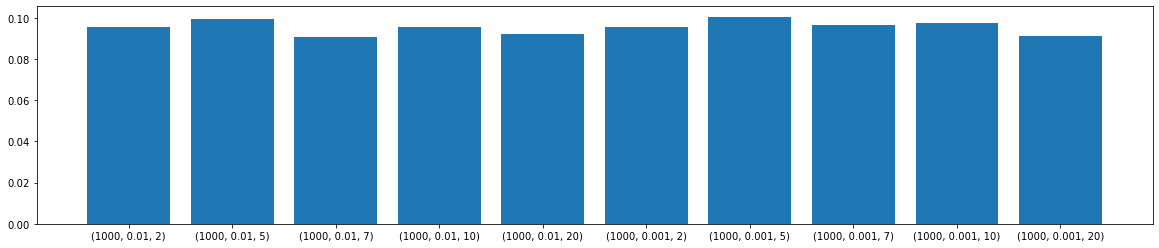

In [125]:
# results

plt.figure(figsize=(20,4))
plt.bar(range(len(results)), results.values(), align='center')
plt.xticks(range(len(results)), results.keys())

plt.show()

### Analysis
- Factors = 2 has given best results
- Regularization best value is 0.01

In [126]:
# lets try with more iterations

factors = [2,3,4,5]
regularizations = [0.01]
iterations = [1500, 2000]

results = {}

for i in iterations:
    for r in regularizations:
        for f in factors:
            model = implicit.als.AlternatingLeastSquares(factors=f, regularization=r, iterations=i, calculate_training_loss=False)
            model.fit(train_als, show_progress=False)
            precision_at_10 = implicit.evaluation.precision_at_k(model, train_als.T, test_als.T, 10, show_progress=False)
            
            results[(i, r, f)] = precision_at_10
            print(f'Finished iterations:{i}, regularization: {r}, factors: {f}: {precision_at_10}')
            


Finished iterations:1500, regularization: 0.01, factors: 2: 0.09508686717728376
Finished iterations:1500, regularization: 0.01, factors: 3: 0.10993835232579861
Finished iterations:1500, regularization: 0.01, factors: 4: 0.10564169624509621
Finished iterations:1500, regularization: 0.01, factors: 5: 0.1002241733607323
Finished iterations:2000, regularization: 0.01, factors: 2: 0.09630113954791705
Finished iterations:2000, regularization: 0.01, factors: 3: 0.10835045768727816
Finished iterations:2000, regularization: 0.01, factors: 4: 0.1024659069680553
Finished iterations:2000, regularization: 0.01, factors: 5: 0.09751541191855034


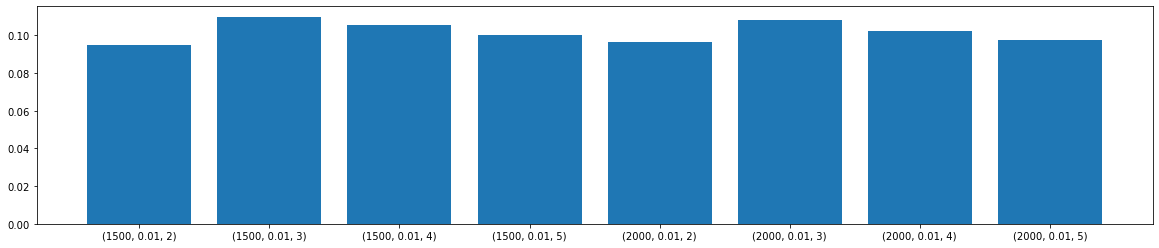

In [127]:
# results

plt.figure(figsize=(20,4))
plt.bar(range(len(results)), results.values(), align='center')  # python 2.x
plt.xticks(range(len(results)), results.keys())  # in python 2.x

plt.show()

### Analysis
- Factors = 3 has given best results
- Regularization best value is 0.01
- Iterations 1500 has given better results

In [128]:
# lets try with more factors less than 10

factors = [8,9,10,11]
regularizations = [0.01]
iterations = [1500]

results = {}

for i in iterations:
    for r in regularizations:
        for f in factors:
            model = implicit.als.AlternatingLeastSquares(factors=f, regularization=r, iterations=i, calculate_training_loss=False)
            model.fit(train_als, show_progress=False)
            precision_at_10 = implicit.evaluation.precision_at_k(model, train_als.T, test_als.T, 10, show_progress=False)
            
            results[(i, r, f)] = precision_at_10
            print(f'Finished iterations:{i}, regularization: {r}, factors: {f}: {precision_at_10}')
            


Finished iterations:1500, regularization: 0.01, factors: 8: 0.09564730057911451
Finished iterations:1500, regularization: 0.01, factors: 9: 0.1002241733607323
Finished iterations:1500, regularization: 0.01, factors: 10: 0.09639454511488885
Finished iterations:1500, regularization: 0.01, factors: 11: 0.09527367831122735


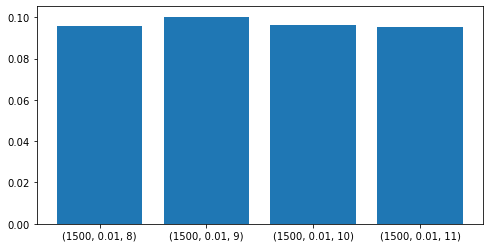

In [129]:
# results

plt.figure(figsize=(8,4))
plt.bar(range(len(results)), results.values(), align='center')  # python 2.x
plt.xticks(range(len(results)), results.keys())  # in python 2.x

plt.show()

### Conclusion of ALS hyperparameters search
- Best results are given by following
    - factors = 3
    - iterations = 1500
    - regularization = 0.01


# Modularize code
- We will create one class 'NewsRecommender'
- This class trains collaborative, als and content based model
- This class recommends top k items based on user and item
- This class can recommend based on hybrid recommendations
- When user logs in for first time in a day, we will recommend news items based on only user id
- When user clicks on one of the articles, we will use user id as well as item id for recommendation




*Design decision : It is always better to keep classes simple. Here, since we need an easy way to train the model using all available options, I am creating a single class which contains all methods and hybrid of all methods for recommendation. It is also very easy to separate the logic into different classes, but for simplicity, I have kept everything in one class.*


In [130]:
# import required modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity

class NewsRecommender():
    def __init__(self, df_platform_content, df_consumer_transactions):
        self.df_platform_content = df_platform_content
        self.df_consumer_transactions = df_consumer_transactions
        self.train_content_based()
        self.train_collaborative_user_based()
        self.train_collaborative_item_based()
        self.train_als()
        
    def train_content_based(self):
        """ 
        Train content based model using title and text_description
        """
        df = self.df_platform_content
        self.df_platform_content = df.assign(tokens = (df['title'] + ' ' + df['text_description']).map(lambda t:self.tokenize(t)))
        self.dictionary = Dictionary(self.df_platform_content.tokens.str.split(','))
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.df_platform_content.tokens.str.split(',')]
        self.tfidf = TfidfModel(self.corpus)
        self.sims = MatrixSimilarity(self.tfidf[self.corpus], num_features=len(self.dictionary))
        
    @staticmethod
    def tokenize(text):
        """
        Tokenize input text. This function performs strip_tags(), strip_punctuation(), strip_multiple_whitespaces(),
        strip_numeric(), remove_stopwords(), strip_short(), stem_text()
        """
        return ','.join(gensim.parsing.preprocessing.preprocess_string(text))
    
    @staticmethod
    def normalize(vals):
        """Use min-max to normalize the list like input data"""
        return (vals - min(vals))/(max(vals) - min(vals))
    
    def recommend_by_content(self, news_text, k=100):
        """
        Recommends item_ids similar to given item_id
        Content based can work with new news articles as well
        """
        news_tokens = self.tokenize(news_text).split(',') 

        news_bow = self.dictionary.doc2bow(news_tokens)
        news_tfidf = self.tfidf[news_bow]

        news_similarity = self.sims[news_tfidf]
        similarity_series = pd.Series(news_similarity.tolist(), index=self.df_platform_content.item_id_mapped)
        similar_item_ids_mapped = similarity_series.sort_values(ascending=False)[1:k+1]

        result = self.df_platform_content[self.df_platform_content.item_id_mapped.isin(similar_item_ids_mapped.index)]

        return zip(list(result['item_id_mapped']), similar_item_ids_mapped)
    
    def train_collaborative_user_based(self):
        """
        user-user collaborative predictions
        """

        data_matrix = self.df_consumer_transactions.pivot(index='consumer_id_mapped', columns='item_id_mapped', values='ratings').fillna(0)
        user_similarity = 1 - pairwise_distances(data_matrix, metric='cosine')
        user_predicted_ratings = np.dot(user_similarity, data_matrix.fillna(0))
        
        self.user_based_ratings = pd.DataFrame(user_predicted_ratings, index=data_matrix.index, columns=data_matrix.columns)
        
    def train_collaborative_item_based(self):
        """
        item-item collaborative predictions
        """

        data_matrix = self.df_consumer_transactions.pivot(index='consumer_id_mapped', columns='item_id_mapped', values='ratings').fillna(0)
        item_similarity = 1 - pairwise_distances(data_matrix.T, metric='cosine')
        
        self.item_based_similarity = pd.DataFrame(item_similarity, index=data_matrix.T.index, columns=data_matrix.T.index)
        
    def recommend_by_user_id(self, userId, k=100):
        """Uses collaborative method"""
        return self.user_based_ratings.loc[userId].sort_values(ascending=False)[:k]
    
    def recommend_by_item_id(self, itemId, k=100): 
        """Uses collaborative method"""
        return news_recommender.item_based_similarity.loc[itemId].sort_values(ascending=False)[1:k]
    
    def train_als(self):
        """Trains the ALS model"""
        df = self.df_consumer_transactions
        self.sparse_user_item = csr_matrix((list([1]*df.ratings), (df['consumer_id_mapped'], df['item_id_mapped']) ))
        self.sparse_item_user = self.sparse_user_item.T.tocsr()
        self.als_model = implicit.als.AlternatingLeastSquares(factors=3, regularization=0.01, iterations=1500, calculate_training_loss=False)
        self.als_model.fit(self.sparse_item_user, show_progress=False)
        
    def recommend_by_item_id_als(self, itemId, k=100):
        """Recommendation of similar items using als model"""
        temp_df = pd.DataFrame(self.als_model.similar_items(itemId, k), columns=['item_id_mapped', 'by_item_als'])
        temp_df = temp_df.set_index('item_id_mapped')
        temp_df = news_recommender.normalize(temp_df.by_item_als)
        return temp_df
    
    def recommend_by_user_id_als(self, userId, k=100):
        """Recommendation of similar users using als model"""
        temp_df = pd.DataFrame(self.als_model.recommend(userId, self.sparse_user_item, k), columns=['item_id_mapped', 'by_user_als'])
        temp_df = temp_df.set_index('item_id_mapped')
        temp_df = self.normalize(temp_df.by_user_als)
        return temp_df
        
    def hybrid_recommendation(self, userId = None, itemId = None, k=10, useAls = True, useCollaborative = True, useContent = True):
        """Recommendation using hybrid technique"""
        predictions = None
        item_predictions = None
        user_predictions = None
        if userId is not None:
            predictions_by_user = pd.DataFrame(self.normalize(self.recommend_by_user_id(userId)))
            predictions_by_user.columns = ['by_user']
            
            predictions_by_als = pd.DataFrame(self.recommend_by_user_id_als(userId))
            
            user_predictions = None
            
            if useAls:
                user_predictions = pd.concat([user_predictions, predictions_by_als], axis=1)
            if useCollaborative:
                user_predictions = pd.concat([user_predictions, predictions_by_user], axis=1)
            
        if itemId is not None:
            predictions_by_item = pd.DataFrame(self.normalize(self.recommend_by_item_id(itemId)))
            predictions_by_item.columns = ['by_item']
            
            # find recommendation by content
            news_item = self.df_platform_content[self.df_platform_content.item_id_mapped == itemId]
            news_text = news_item['title'] + ' ' + news_item['text_description']
            
            predictions_by_content = pd.DataFrame(self.recommend_by_content(news_text.values[0]), columns=['item_id_mapped', 'by_content'])
            predictions_by_content = predictions_by_content.set_index('item_id_mapped')
            predictions_by_content.by_content = self.normalize(predictions_by_content.by_content)
            
            predictions_by_als = self.recommend_by_item_id_als(itemId)
            
            if useAls:
                item_predictions = pd.concat([item_predictions, predictions_by_als], axis=1)
            if useCollaborative:
                item_predictions = pd.concat([item_predictions, predictions_by_item], axis=1)
            if useContent:
                item_predictions = pd.concat([item_predictions, predictions_by_content], axis=1)
            
            
        predictions = pd.concat([user_predictions, item_predictions], axis=1)
        
        predictions = predictions.fillna(0)
        predictions['hybrid_score'] = predictions.sum(axis=1)
        
        valid_item_ids = predictions.index.isin(self.df_platform_content.item_id_mapped)
        predictions = predictions.loc[valid_item_ids]
        
        if (userId):
            already_watched = self.df_consumer_transactions[self.df_consumer_transactions.consumer_id_mapped == userId].item_id_mapped
            predictions = predictions[~predictions.index.isin(already_watched)]
            
        predictions = predictions.sort_values(by='hybrid_score', ascending=False)
        
        predictions = predictions[:k]
        
        pred_content = self.df_platform_content.set_index('item_id_mapped').loc[predictions.index][['title', 'item_url']]
        
        return pd.concat([predictions, pred_content], axis=1)

In [131]:
class EvaluateRecommendations():
    """This class evaluates the recommendations"""
    def __init__(self, model, train, test, k=10):
        self.model = model
        self.train = train.copy()
        self.test = test.copy()
        
        # filter test set to contain only consumer and items from train set
        self.test = self.test[self.test.consumer_id_mapped.isin(self.train.consumer_id_mapped) & self.test.item_id_mapped.isin(self.train.item_id_mapped)]
        
        self.train = self.calc_pred_ratings(self.train.copy())
        self.test = self.calc_pred_ratings(self.test.copy())
        
        self.rmse_train = self.calc_rmse(self.train)
        self.rmse_test = self.calc_rmse(self.test)
        
        self.mae_train = self.calc_mae(self.train)
        self.mae_test = self.calc_mae(self.test)
        
        self.gpatk_train = self.calc_global_precision_at_k(self.train, k)
        self.gpatk_test = self.calc_global_precision_at_k(self.test, k)  
        
        self.summary()

    def calc_pred_ratings(self, df):
        """Calculates predicted ratings"""
        df = df.assign(predicted_ratings=[self.model.user_based_ratings.loc[consumerId][itemId] for itemId,consumerId,rating in df.to_numpy()])
        df['predicted_ratings'] = df.predicted_ratings.map(lambda a: a if a <= 5 else 5)
        return df
        
    def calc_rmse(self, df):
        """Calculate RMSE score"""
        return sqrt(mean_squared_error(df.predicted_ratings, df.ratings))
    
    def calc_mae(self, df):
        """Calculate MAE score"""
        return mean_absolute_error(df.predicted_ratings, df.ratings)
    
    def calc_precision_at_k(self, df, consumerId, k=10):
        """Calculate Precision@K"""
        by_ratings = df[df.consumer_id_mapped == consumerId].sort_values(by='ratings', ascending=False)[:k].item_id_mapped
        by_pred_ratings = df[df.consumer_id_mapped == consumerId].sort_values(by='predicted_ratings', ascending=False)[:k].item_id_mapped

        return by_pred_ratings.isin(by_ratings).sum()/k
    
    def calc_global_precision_at_k(self, df, k=10):
        """Calculate Global Precision@K"""
        return sum([self.calc_precision_at_k(df, consumerId, k) for consumerId in df.consumer_id_mapped.unique()])/len(df.consumer_id_mapped.unique())
    
    def summary(self):
        """Prints summary"""
        print('RMSE(train): ', self.rmse_train)
        print('RMSE(test): ', self.rmse_test)
        
        print('MAE(train): ', self.mae_train)
        print('MAE(test): ', self.mae_test)
        
        print('Global Precision at K(train): ', self.gpatk_train)
        print('Global Precision at K(test): ', self.gpatk_test)

# Creating data pipeline
We will perform following things in data pipeline
- Load the data
- Preprocess
- Filter only required columns
- Train the model

This process would be required to be executed based on the frequency of data change

In [132]:
# load the data
consumer_transactions = pd.read_csv('./data/consumer_transanctions.csv')
platform_content = pd.read_csv('./data/platform_content.csv')

ratings_dict = {
    'content_followed': 5,
    'content_commented_on': 4,
    'content_saved': 3,
    'content_liked': 2,
    'content_watched': 1
}

# defining common functions
def mapConsumerAndItems(data):
    data = data.assign(consumer_id_mapped = data.consumer_id.map(mapConsumerIdToNumber))
    data = data.assign(item_id_mapped = data.item_id.map(mapItemIdToNumber))    
    return data

def mapItems(data):
    data = data.assign(item_id_mapped = data.item_id.map(mapItemIdToNumber))    
    return data

C:\Users\adi00\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
# preprocess the data
platform_content = platform_content[platform_content.interaction_type != 'content_pulled_out'] # filter pulled out content

platform_content = platform_content[platform_content.language == 'en'] # filter only english content

# filter only required columns
platform_content_df = platform_content[['item_id', 'title', 'text_description', 'item_url']] # filter only required columns

consumer_transactions['ratings'] = consumer_transactions.interaction_type.map(ratings_dict) # create ratings column

### Try with max rating for duplicate records
Sometimes user watch an item, later follow same item and again like or watch the same item.

We will try picking max of such duplicate interactions and evaluate the result

In [134]:
# train the model
# picking max of duplicate ratings

df = pd.DataFrame(consumer_transactions.groupby(['item_id', 'consumer_id']).ratings.max()).reset_index()
df_train, df_test = train_test_split(df, test_size=0.20, random_state=7)

df_train = mapConsumerAndItems(df_train)
df_test = mapConsumerAndItems(df_test)
required_cols = ['item_id_mapped', 'consumer_id_mapped', 'ratings']

platform_content_df = mapItems(platform_content_df)
platform_content_df = platform_content_df[platform_content_df.item_id_mapped.isin(df_train.item_id_mapped)]

news_recommender = NewsRecommender(platform_content_df, df_train[required_cols])

In [135]:
evaluations = EvaluateRecommendations(news_recommender, df_train[required_cols], df_test[required_cols], 10)

RMSE(train):  2.4288972099171846
RMSE(test):  1.6644192266851663
MAE(train):  2.013733735077249
MAE(test):  1.2154986208173466
Global Precision at K(train):  0.43413173652695075
Global Precision at K(test):  0.34401606425703224


### Try with sum of all ratings
Sometimes user watch an item, later follow same item and again like or watch the same item.

Now sometimes user just watches the same article multiple number of times. Since user is reading the article multiple times, user must like it even though not liked explicitely. So, this time, we will just use sum of all such interactions (instead of picking max from all interactions)

In [136]:
# train the model
# picking ratings such that each time article is 
# watched ratings is increased by 1,
# liked then rating is increased by 2,
# saved then rating is increased by 3,
# commented then rating is increased by 4,
# followed then rating is increased by 5

df = pd.DataFrame(consumer_transactions.groupby(['item_id', 'consumer_id']).ratings.sum()).reset_index()
df_train, df_test = train_test_split(df, test_size=0.20, random_state=7)

df_train = mapConsumerAndItems(df_train)
df_test = mapConsumerAndItems(df_test)
required_cols = ['item_id_mapped', 'consumer_id_mapped', 'ratings']

platform_content_df = mapItems(platform_content_df)
platform_content_df = platform_content_df[platform_content_df.item_id_mapped.isin(df_train.item_id_mapped)]

news_recommender = NewsRecommender(platform_content_df, df_train[required_cols])

In [137]:
evaluations = EvaluateRecommendations(news_recommender, df_train[required_cols], df_test[required_cols], 10)

RMSE(train):  3.457004689372939
RMSE(test):  2.9901039625196657
MAE(train):  2.265016824043806
MAE(test):  1.8826435582063417
Global Precision at K(train):  0.44589003810561195
Global Precision at K(test):  0.34706827309237376


## We see that with sum of all ratings, we get slightly better Global Precision@K (k=10) result

### Logic behind considering precison at k
- We will recommend only top 10 articles to the user
- Hence, instead of finding the ratings for all items, we can just use precision at k
- Precision at k will evaluate the recommendations for only top k predictions

# Predictions

In [138]:
input_user_id = 2947963873628556360
input_item_id = -6642751159620064055

# map ids
mapped_input_user_id = mapConsumerIdToNumber.get(input_user_id)
mapped_input_item_id = mapItemIdToNumber.get(input_item_id)

# recommendation at the start of day (only using user id). Not using ALS because it has given low precision at k
news_recommender.hybrid_recommendation(mapped_input_user_id, None, k = 10, useAls = False)

,by_user,hybrid_score,title,item_url
item_id_mapped,,,,
712,0.067153,0.067153,Drupal and ambitious digital experiences,http://buytaert.net/drupal-is-for-ambitious-di...
425,0.045456,0.045456,Seniority,http://merowing.info/2017/01/seniority/
378,0.036711,0.036711,Lightning Distribution for Drupal: Build Advan...,https://www.acquia.com/resources/webinars/ligh...
2176,0.035519,0.035519,The Children's Illustrated Guide to Kubernetes,https://deis.com/blog/2016/kubernetes-illustra...
2950,0.034296,0.034296,Pull request first - Practical Blend,https://medium.com/practical-blend/pull-reques...
1628,0.025036,0.025036,Labelling automated builds on Docker Hub - Mic...,https://medium.com/microscaling-systems/labell...
1732,0.023293,0.023293,The brilliant mechanics of Pokémon Go,https://techcrunch.com/2016/07/11/the-brillian...
431,0.022933,0.022933,The Death of Drupal Commerce as an Ecommerce S...,https://medium.com/third-grove/the-death-of-dr...
2883,0.022627,0.022627,Release Day: Extend Drupal 8 with Plugins,https://drupalize.me/blog/201611/release-day-e...


In [139]:
input_user_id = 2947963873628556360
input_item_id = -6642751159620064055

# map ids
mapped_input_user_id = mapConsumerIdToNumber.get(input_user_id)
mapped_input_item_id = mapItemIdToNumber.get(input_item_id)

# recommendation after user clicks on one of the item. Not using ALS because it has given low precision at k
news_recommender.hybrid_recommendation(mapped_input_user_id, mapped_input_item_id, k = 10, useAls = False)

,by_user,by_item,by_content,hybrid_score,title,item_url
item_id_mapped,,,,,,
851,0.000000,0.084337,1.000000,1.084337,Acquia's Dev Desktop - a Drupal server for beg...,http://www.mediacurrent.com/blog/acquia-dev-de...
31,0.000000,0.000000,0.846269,0.846269,Drupal How-To: Responsive or Adaptive Images? ...,https://dev.acquia.com/blog/drupal-howto-respo...
17,0.000000,0.000000,0.729727,0.729727,"New blog from Dries: A ""MAP"" for accelerating ...",http://us8.campaign-archive1.com/?u=eb2d2e4ce4...
648,0.006877,0.019415,0.528358,0.554650,Coder | Drupal.org,https://www.drupal.org/project/coder
2619,0.000000,0.000000,0.496333,0.496333,New blog from Dries: How should you decouple D...,http://us8.campaign-archive1.com/?u=eb2d2e4ce4...
1454,0.000000,0.000000,0.436891,0.436891,C/C++ extension for Visual Studio Code,https://blogs.msdn.microsoft.com/vcblog/2016/0...
795,0.000000,0.000000,0.340104,0.340104,Dries Buytaert,http://buytaert.net/improving-drupal-content-w...
1792,0.000000,0.000000,0.335857,0.335857,Writing good code: how to reduce the cognitive...,http://chrismm.com/blog/how-to-reduce-the-cogn...
395,0.000000,0.000000,0.305831,0.305831,State of Drupal 2016 survey | Dries Buytaert,http://buytaert.net/state-of-drupal-2016-survey


### Precision at k for various methods
- Collaborative (user based) - 0.35
- ALS (user based) - 0.10

We see that collaborative is slightly better. We can give following weightage before final prediction.
- Weightage for collaborative = 0.35/(0.35 + 0.10) = 0.75
- Weightage for als = 0.1/(0.35 + 0.10) = 0.25

In [140]:
# prediction using collaborative and als (user based) without weightage

news_recommender.hybrid_recommendation(mapped_input_user_id, None, k = 10, useAls = True)

,by_user_als,by_user,hybrid_score,title,item_url
item_id_mapped,,,,,
554,0.702549,0.002571,0.705119,Introducing LambCI - a serverless build system,https://medium.com/@hichaelmart/lambci-4c3e29d...
1889,0.619220,0.009816,0.629035,The Continuous Delivery Maturity Model,https://www.infoq.com/articles/Continuous-Deli...
919,0.610890,0.014711,0.625601,Do You Suffer From Deployment Anxiety? - DZone...,https://dzone.com/articles/do-you-suffer-from-...
425,0.574891,0.045456,0.620347,Seniority,http://merowing.info/2017/01/seniority/
549,0.618982,0.000000,0.618982,How it feels to learn Javascript in 2016,https://hackernoon.com/how-it-feels-to-learn-j...
842,0.484623,0.000000,0.484623,Why Learning Angular 2 Was Excruciating,https://hackernoon.com/why-learning-angular-2-...
2488,0.442684,0.015268,0.457953,The hardest thing in computer science,http://blog.kaczmarzyk.net/2016/10/03/the-hard...
1024,0.431299,0.015868,0.447168,Things you probably didn't know you could do w...,https://medium.freecodecamp.com/10-tips-to-max...
855,0.418479,0.007129,0.425608,Android Studio 2.2,http://android-developers.blogspot.com.br/2016...


In [141]:
# prediction using collaborative and als (user based) with weightage
df_recommendation = news_recommender.hybrid_recommendation(mapped_input_user_id, None, k = 10, useAls = True)

# updating results based on weightage
df_recommendation.by_user_als = df_recommendation.by_user_als * 0.25
df_recommendation.by_user = df_recommendation.by_user * 0.75
df_recommendation.hybrid_score = df_recommendation.by_user_als + df_recommendation.by_user
df_recommendation = df_recommendation.sort_values(by='hybrid_score', ascending=False)
df_recommendation

,by_user_als,by_user,hybrid_score,title,item_url
item_id_mapped,,,,,
425,0.143723,0.034092,0.177815,Seniority,http://merowing.info/2017/01/seniority/
554,0.175637,0.001928,0.177565,Introducing LambCI - a serverless build system,https://medium.com/@hichaelmart/lambci-4c3e29d...
919,0.152722,0.011033,0.163756,Do You Suffer From Deployment Anxiety? - DZone...,https://dzone.com/articles/do-you-suffer-from-...
1889,0.154805,0.007362,0.162167,The Continuous Delivery Maturity Model,https://www.infoq.com/articles/Continuous-Deli...
549,0.154745,0.000000,0.154745,How it feels to learn Javascript in 2016,https://hackernoon.com/how-it-feels-to-learn-j...
2488,0.110671,0.011451,0.122122,The hardest thing in computer science,http://blog.kaczmarzyk.net/2016/10/03/the-hard...
842,0.121156,0.000000,0.121156,Why Learning Angular 2 Was Excruciating,https://hackernoon.com/why-learning-angular-2-...
1024,0.107825,0.011901,0.119726,Things you probably didn't know you could do w...,https://medium.freecodecamp.com/10-tips-to-max...
855,0.104620,0.005346,0.109966,Android Studio 2.2,http://android-developers.blogspot.com.br/2016...


In [144]:
# trying different models

# als + content
news_recommender.hybrid_recommendation(mapped_input_user_id, mapped_input_item_id, k = 10, useCollaborative = False)

,by_user_als,by_item_als,by_content,hybrid_score,title,item_url
item_id_mapped,,,,,,
554,0.702549,0.683614,0.000000,1.386163,Introducing LambCI - a serverless build system,https://medium.com/@hichaelmart/lambci-4c3e29d...
31,0.000000,0.380396,0.846269,1.226665,Drupal How-To: Responsive or Adaptive Images? ...,https://dev.acquia.com/blog/drupal-howto-respo...
851,0.000000,0.000000,1.000000,1.000000,Acquia's Dev Desktop - a Drupal server for beg...,http://www.mediacurrent.com/blog/acquia-dev-de...
2992,0.000000,0.988959,0.000000,0.988959,Configuring OSGi,https://docs.adobe.com/docs/en/aem/6-1/deploy/...
1637,0.000000,0.988940,0.000000,0.988940,How to Install and Use the Linux Bash Shell on...,http://www.howtogeek.com/249966/how-to-install...
1485,0.000000,0.940045,0.000000,0.940045,Drupal 8 CI/CD with Docker via Jenkins. Part 1...,https://blog.wodby.com/drupal-8-ci-cd-with-jen...
1068,0.000000,0.935156,0.000000,0.935156,Using Google Analytics with Leadfeeder for B2B...,https://analytics.googleblog.com/2016/09/using...
170,0.000000,0.926499,0.000000,0.926499,Hacked Website Report - 2016/Q3,https://blog.sucuri.net/2017/01/hacked-website...
1810,0.000000,0.890189,0.000000,0.890189,Up your DevOps chops with this online Kubernet...,https://cloudplatform.googleblog.com/2016/05/u...


In [145]:
# collaborative + content

news_recommender.hybrid_recommendation(mapped_input_user_id, mapped_input_item_id, k = 10, useAls = False)

,by_user,by_item,by_content,hybrid_score,title,item_url
item_id_mapped,,,,,,
851,0.000000,0.084337,1.000000,1.084337,Acquia's Dev Desktop - a Drupal server for beg...,http://www.mediacurrent.com/blog/acquia-dev-de...
31,0.000000,0.000000,0.846269,0.846269,Drupal How-To: Responsive or Adaptive Images? ...,https://dev.acquia.com/blog/drupal-howto-respo...
17,0.000000,0.000000,0.729727,0.729727,"New blog from Dries: A ""MAP"" for accelerating ...",http://us8.campaign-archive1.com/?u=eb2d2e4ce4...
648,0.006877,0.019415,0.528358,0.554650,Coder | Drupal.org,https://www.drupal.org/project/coder
2619,0.000000,0.000000,0.496333,0.496333,New blog from Dries: How should you decouple D...,http://us8.campaign-archive1.com/?u=eb2d2e4ce4...
1454,0.000000,0.000000,0.436891,0.436891,C/C++ extension for Visual Studio Code,https://blogs.msdn.microsoft.com/vcblog/2016/0...
795,0.000000,0.000000,0.340104,0.340104,Dries Buytaert,http://buytaert.net/improving-drupal-content-w...
1792,0.000000,0.000000,0.335857,0.335857,Writing good code: how to reduce the cognitive...,http://chrismm.com/blog/how-to-reduce-the-cogn...
395,0.000000,0.000000,0.305831,0.305831,State of Drupal 2016 survey | Dries Buytaert,http://buytaert.net/state-of-drupal-2016-survey


# Evaluation technique suggestion
Once we deploy this model, we have to evaluate it using online method. 

This will help us find out how much our model is helping our readers

#### Offline evaluation technique:
- We will ask users (periodically) if they are liking the recommendation given by the system

#### Using metrics
- We will train the model using set frequency (once every hour or once every 6 hours or once every day etc.)
- We will evaluate the model using offline method at the end of every day
- To do that using offline method, we will devide the data in train and test
- Find recommended news articles using train set
- Find predicted ratings for test set
- Use metrics such as RMSE, MAE and check if its improving
- Using test set, check how much of recommended articles overlaps with actual articles read by the user
- We can also use other metrics such as hit rate

#### AB testing:
- We will create groups of users
- For one set of users, we will show the news articles as suggested by recommendation engine
- For another set of users, we will show random articles
- We will compare the two and find the efficacy of the model
